# Mercury Data Compilation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from scipy import interpolate
from scipy.interpolate import interp1d
import seaborn as sns

# Final Data Sources 
- non used data is removed in this notebook

In [2]:
# True mccord data digitized on 4/21/1976
mccord_digitized= pd.read_csv('mccord_fig2_4_21_1976.csv')
# Domingue Digitized (not Mallama)
domingue_digitized= pd.read_csv('domingue_fig8_PA74.csv')
# Mallama et al. 2017 Johnson Cousins filters 
mallama2017= np.genfromtxt('mercury_mallama2017geoalbedo.txt')
# Averaged "reflectance" from Izenberg et al. 2014
izenberg2014= pd.read_csv('izenberg2014_fig5a_avgreflectance.csv')
# Klima et al. 2018
# High Reflectance Plains & Region 2 are included from their work (Reflectance units)
klima_hrp= pd.read_csv('klima_fig2_HRP.csv')
klima_r2= pd.read_csv('klima_fig2a_Region2.csv')

In [3]:
# Since we don't have data for phase angle=0 use the phase integral (PSG eqn 77) to try to simulate by dividing the values for 40 by the coefficient for 40 degree phase
def get_scale_factor_lambert(phase_angle): # phase angle in degrees
    scale_val= (1/np.pi)*(np.sin(np.deg2rad(phase_angle))+(np.pi-np.deg2rad(phase_angle))*np.cos(np.deg2rad(phase_angle)))
    return scale_val
# Use eqn 78 from PSG handbook. the P(g) term is for small bodies, but with an entire planet we will just use one (this is what geronimo said)
def get_scale_factor_LS(phase_angle): # phase angle in degrees
    scale_val= (1-(np.sin(np.deg2rad(phase_angle)/2)*np.tan(np.deg2rad(phase_angle)/2)*np.log(1/(np.tan(np.deg2rad(phase_angle)/4)))))
    return scale_val 

In [4]:
cb_palette= sns.color_palette("colorblind")

## Moving forward I am slicing the McCord data to <2.1 microns to reduce the noisiest part of the signal...
- a similar method was applied in Mallama 2017

## Below plot is only to reference the original data

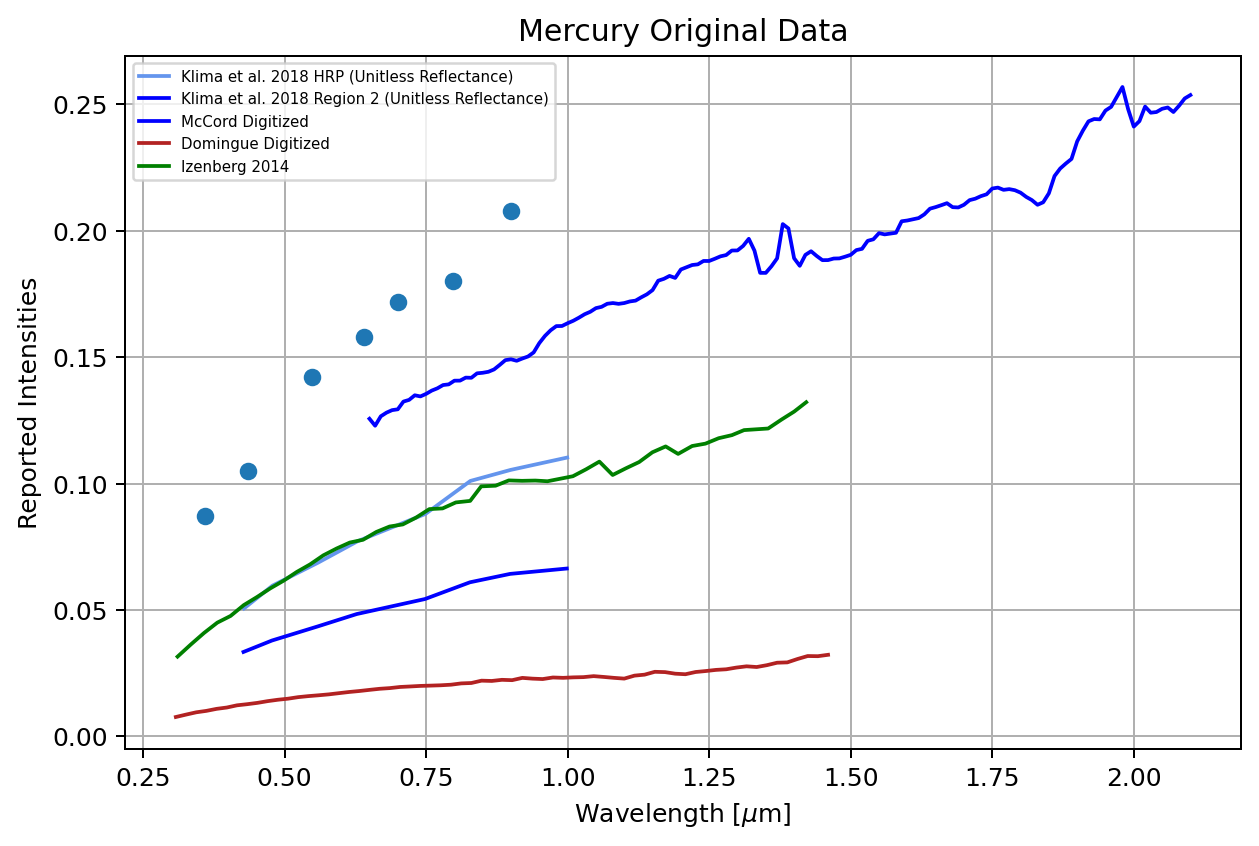

In [5]:
plt.figure(figsize=(8,5), dpi=180)
# KLIMA DATA SETS
plt.plot(klima_hrp['x'],klima_hrp['y'], label='Klima et al. 2018 HRP (Unitless Reflectance)', color='cornflowerblue')
plt.plot(klima_r2['x'],klima_r2['y'], label='Klima et al. 2018 Region 2 (Unitless Reflectance)', color='blue')
plt.plot(mccord_digitized[mccord_digitized['x']<2.1]['x'],mccord_digitized[mccord_digitized['x']<2.1]['y'], color='blue', label='McCord Digitized')
plt.plot(domingue_digitized['x'], domingue_digitized['y'], color='firebrick', label='Domingue Digitized')
plt.scatter(mallama2017[:,0],mallama2017[:,1])
plt.plot(izenberg2014['x'],izenberg2014['y'], label='Izenberg 2014', color='g')

plt.title('Mercury Original Data')
plt.ylabel('Reported Intensities')
plt.xlabel('Wavelength [$\mu$m]')
plt.legend(fontsize=6)
plt.grid()
#plt.savefig('Mercury_original_data.png');

In [6]:
sns.color_palette("colorblind")

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 (0.9254901960784314, 0.8823529411764706, 0.2),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784)]

# Tri Plot

## Create the composite data to be included in panel C

In [7]:
x_1= list(izenberg2014[izenberg2014['x']<1.41]['x'])
y_1= list(izenberg2014[izenberg2014['x']<1.41]['y']*2)
x_2= mccord_digitized[(mccord_digitized['x']<2.2) & (mccord_digitized['x']>1.41)]['x']
y_2= mccord_digitized[(mccord_digitized['x']<2.2) & (mccord_digitized['x']>1.41)]['y']/get_scale_factor_LS(77.4)*0.66

x_new_list= np.concatenate((x_1, x_2))
y_new_list= np.concatenate((y_1, y_2))
composite_df= pd.DataFrame({'x_1': x_new_list, 'y_1': y_new_list})

composite_df.to_csv('mercury_composite_data.csv', index=False)

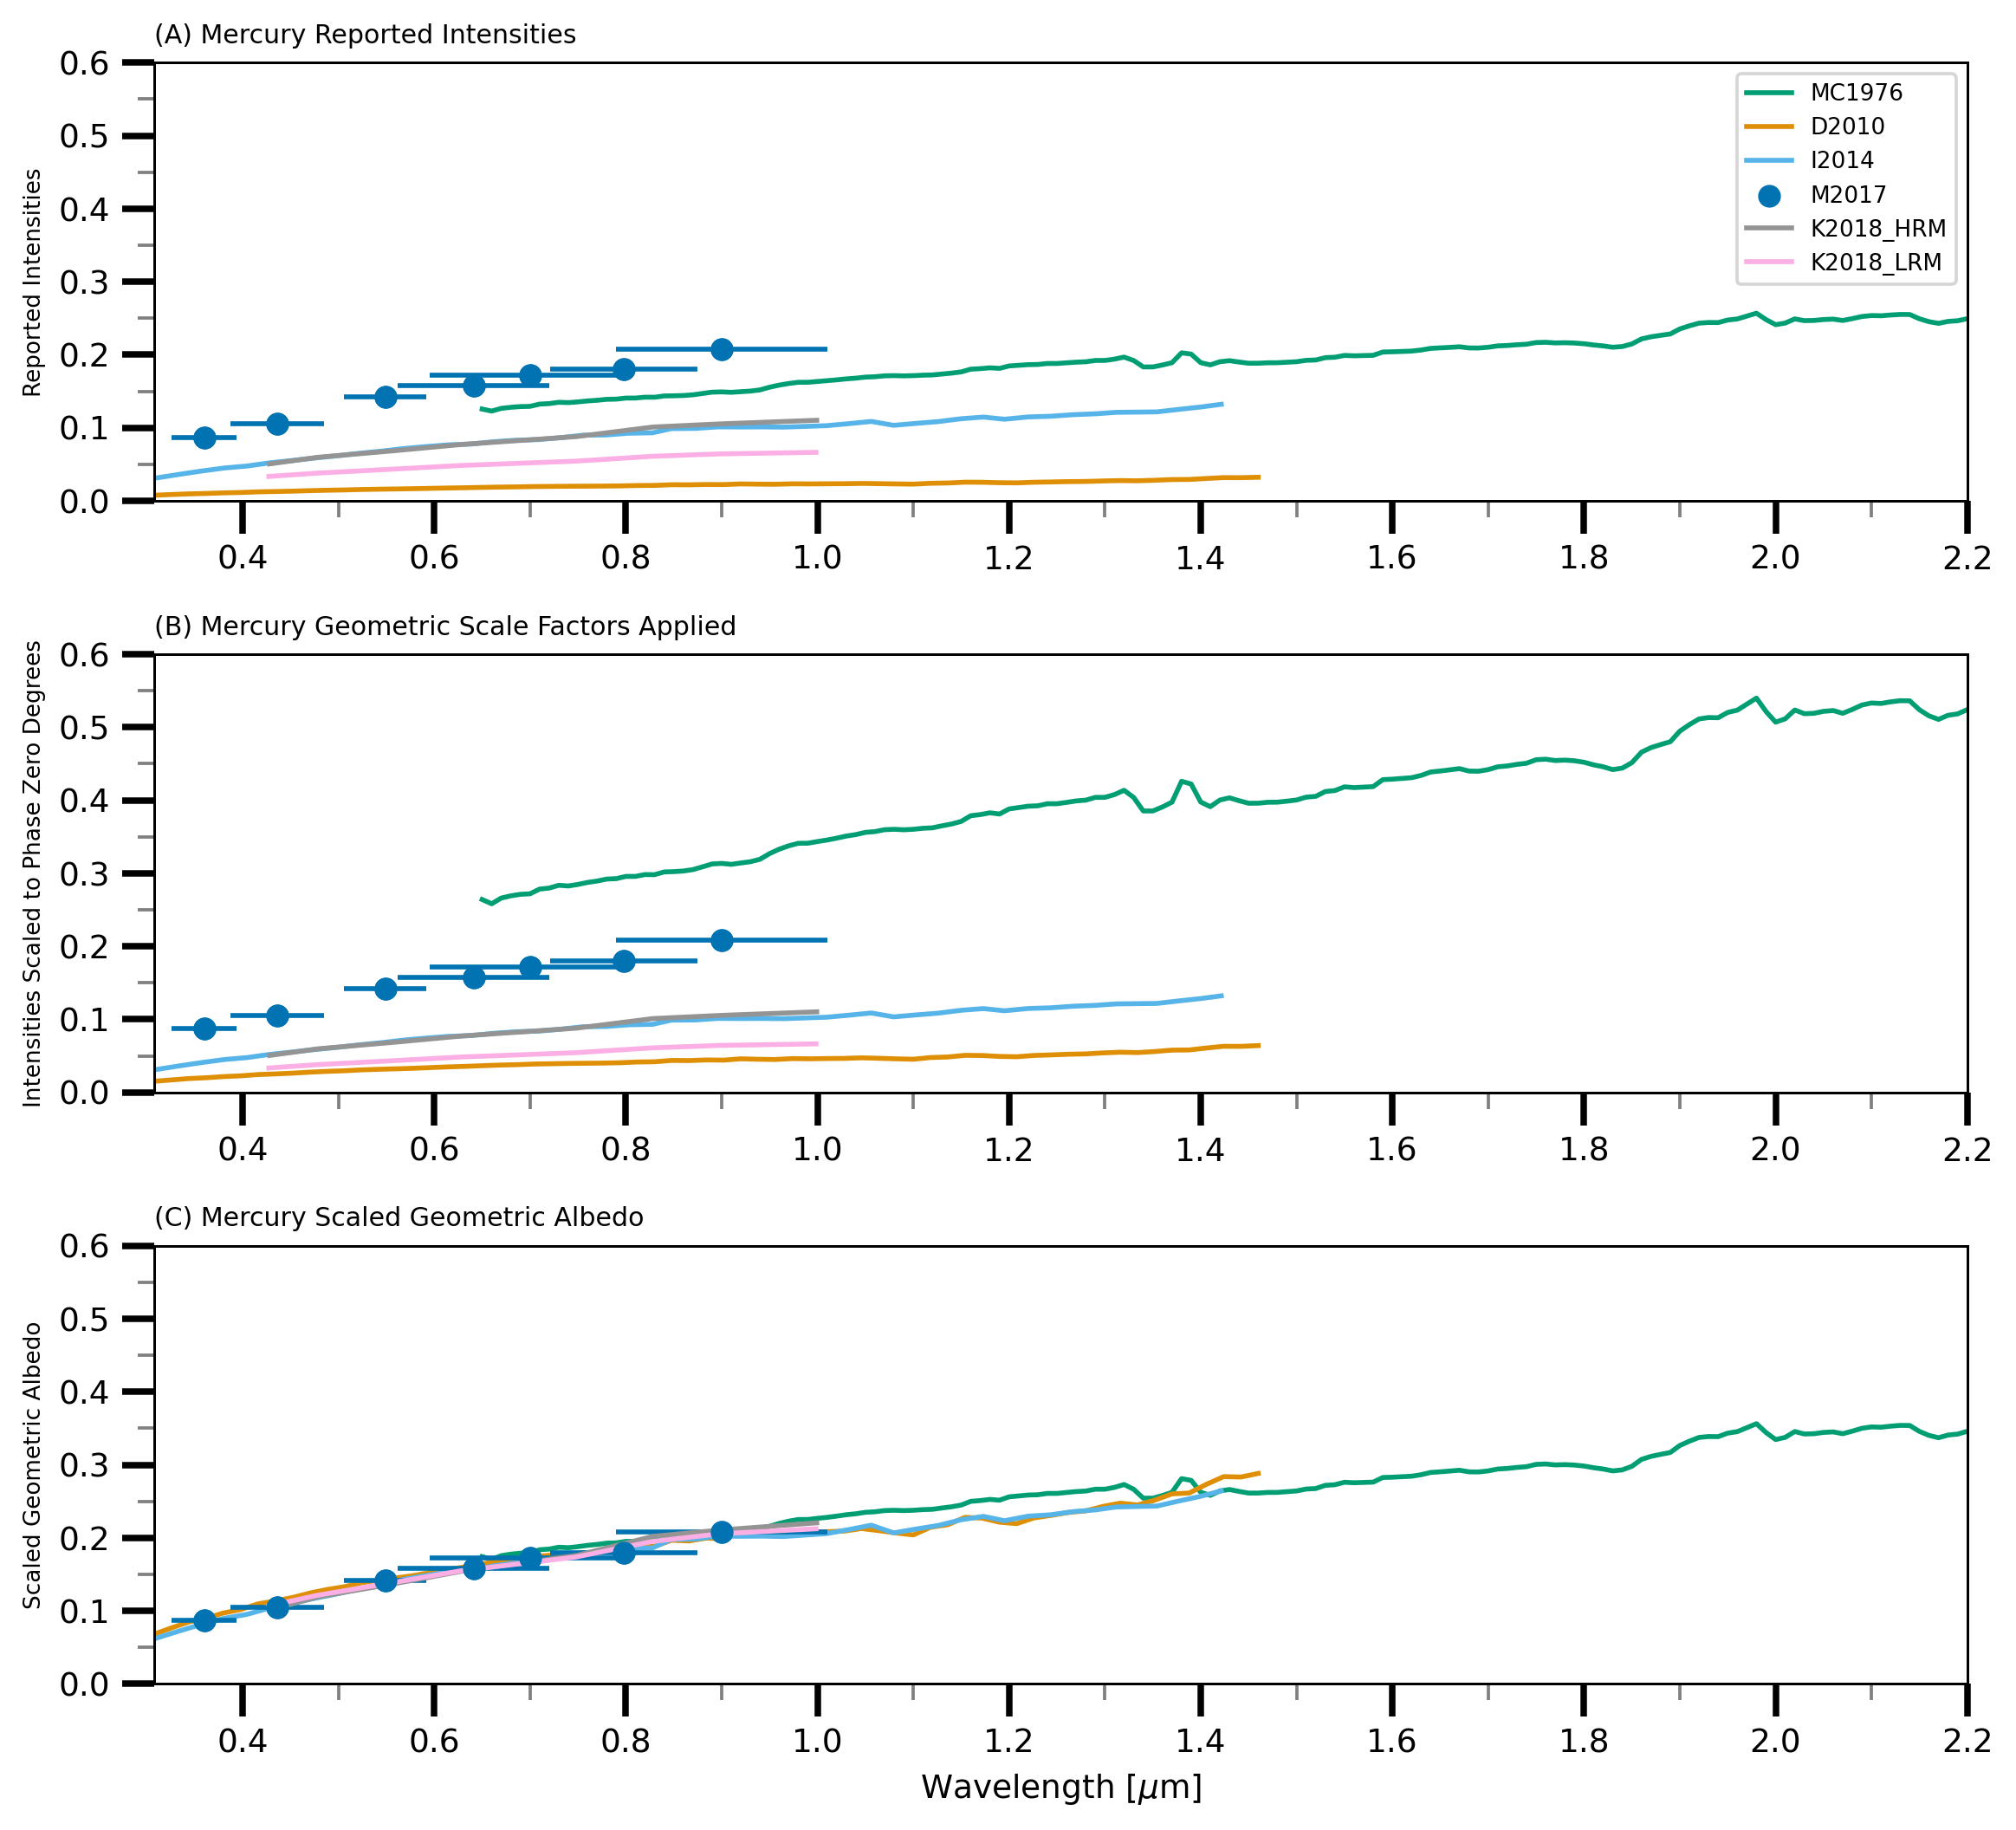

In [11]:
# Create figure and axes
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 9), dpi=270)
plt.subplots_adjust(hspace=0.35)

# DATA 
# FIGURE 1- ORIGINAL DATA
axes[0].plot(mccord_digitized[mccord_digitized['x']<2.2]['x'],mccord_digitized[mccord_digitized['x']<2.2]['y'], color=cb_palette[2], label='MC1976')
axes[0].plot(domingue_digitized['x'], domingue_digitized['y'], color=cb_palette[1], label='D2010')
axes[0].plot(izenberg2014['x'],izenberg2014['y'], label='I2014', color=cb_palette[-1])
axes[0].scatter(mallama2017[:,0],mallama2017[:,1], color=cb_palette[0], label='M2017')
axes[0].errorbar(mallama2017[:,0], mallama2017[:,1], xerr=mallama2017[:,2]/2,fmt='o', color=cb_palette[0])#linestyle='none'
axes[0].plot(klima_hrp['x'],klima_hrp['y'], label='K2018_HRM', color=cb_palette[7])
axes[0].plot(klima_r2['x'],klima_r2['y'], label='K2018_LRM', color=cb_palette[6])

# # FIGURE 2- GEOMETRIC SCALING FACTORS APPLIED
axes[1].plot(mccord_digitized[mccord_digitized['x']<2.2]['x'],mccord_digitized[mccord_digitized['x']<2.2]['y']/get_scale_factor_LS(77.4), color=cb_palette[2], label='MC1976')
axes[1].plot(domingue_digitized['x'], domingue_digitized['y']/get_scale_factor_LS(74), color=cb_palette[1], label='D2010')
axes[1].plot(izenberg2014['x'],izenberg2014['y'], label='I2014', color=cb_palette[-1])
axes[1].scatter(mallama2017[:,0],mallama2017[:,1], color=cb_palette[0], label='M2017')
axes[1].errorbar(mallama2017[:,0], mallama2017[:,1], xerr=mallama2017[:,2]/2,fmt='o', color=cb_palette[0])#linestyle='none'
axes[1].plot(klima_hrp['x'],klima_hrp['y'], label='K2018_HRM', color=cb_palette[7])
axes[1].plot(klima_r2['x'],klima_r2['y'], label='K2018_R2', color=cb_palette[6])

# # # FIGURE 3- EMPIRICAL SCALING FACTORS
axes[2].plot(mccord_digitized[mccord_digitized['x']<2.2]['x'],(mccord_digitized[mccord_digitized['x']<2.2]['y']/get_scale_factor_LS(77.4))*0.66, color=cb_palette[2], label='MC1976')
axes[2].plot(domingue_digitized['x'], domingue_digitized['y']/get_scale_factor_LS(74)*4.5, color=cb_palette[1], label='D2010')
axes[2].plot(izenberg2014['x'],izenberg2014['y']*2, label='I2014', color=cb_palette[-1])
axes[2].scatter(mallama2017[:,0],mallama2017[:,1], color=cb_palette[0], label='M2017')
axes[2].errorbar(mallama2017[:,0], mallama2017[:,1], xerr=mallama2017[:,2]/2,fmt='o', color=cb_palette[0])#linestyle='none'
axes[2].plot(klima_hrp['x'],klima_hrp['y']*2, label='K2018_HRM', color=cb_palette[7])
axes[2].plot(klima_r2['x'],klima_r2['y']*3.2, label='K2018_R2', color=cb_palette[6])
#axes[2].plot(composite_df['x_1'],composite_df['y_1'], linewidth=3, zorder=0, color='black')

# # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~FORMAT~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
for value in range(3):
    # Keeping the tick marks consistent across the plots
    axes[value].xaxis.set_major_locator(MultipleLocator(0.2))
    axes[value].xaxis.set_minor_locator(MultipleLocator(0.1))
    axes[value].yaxis.set_major_locator(MultipleLocator(0.1))
    axes[value].yaxis.set_minor_locator(MultipleLocator(0.05))
    # Customize the appearance of ticks
    axes[value].tick_params(axis='both', which='major', length=10, width=2, color='black')
    axes[value].tick_params(axis='both', which='minor', length=5, width=1, color='gray')
    axes[value].set_ylim(0,0.6)
    axes[value].set_xlim(min(domingue_digitized['x']),2.2)
    
axes[0].set_title('(A) Mercury Reported Intensities', fontsize=8, loc='left')
axes[1].set_title('(B) Mercury Geometric Scale Factors Applied', fontsize=8, loc='left')
axes[2].set_title('(C) Mercury Scaled Geometric Albedo', fontsize=8, loc='left')
axes[0].set_ylabel('Reported Intensities', fontsize=7)
axes[1].set_ylabel('Intensities Scaled to Phase Zero Degrees', fontsize=7)
axes[2].set_ylabel('Scaled Geometric Albedo', fontsize=7)
axes[2].set_xlabel('Wavelength [$\mu$m]')
axes[0].legend(fontsize=7, loc='upper right') #, fancybox=True, shadow=True); #bbox_to_anchor=(0.7, 0.7),
#plt.legend(fontsize=5, loc='upper right')
plt.savefig('final_plots/Mercury_triplot.png', bbox_inches='tight');

# Composite Spectrum 
- (not used in the paper, but shown for reference here)

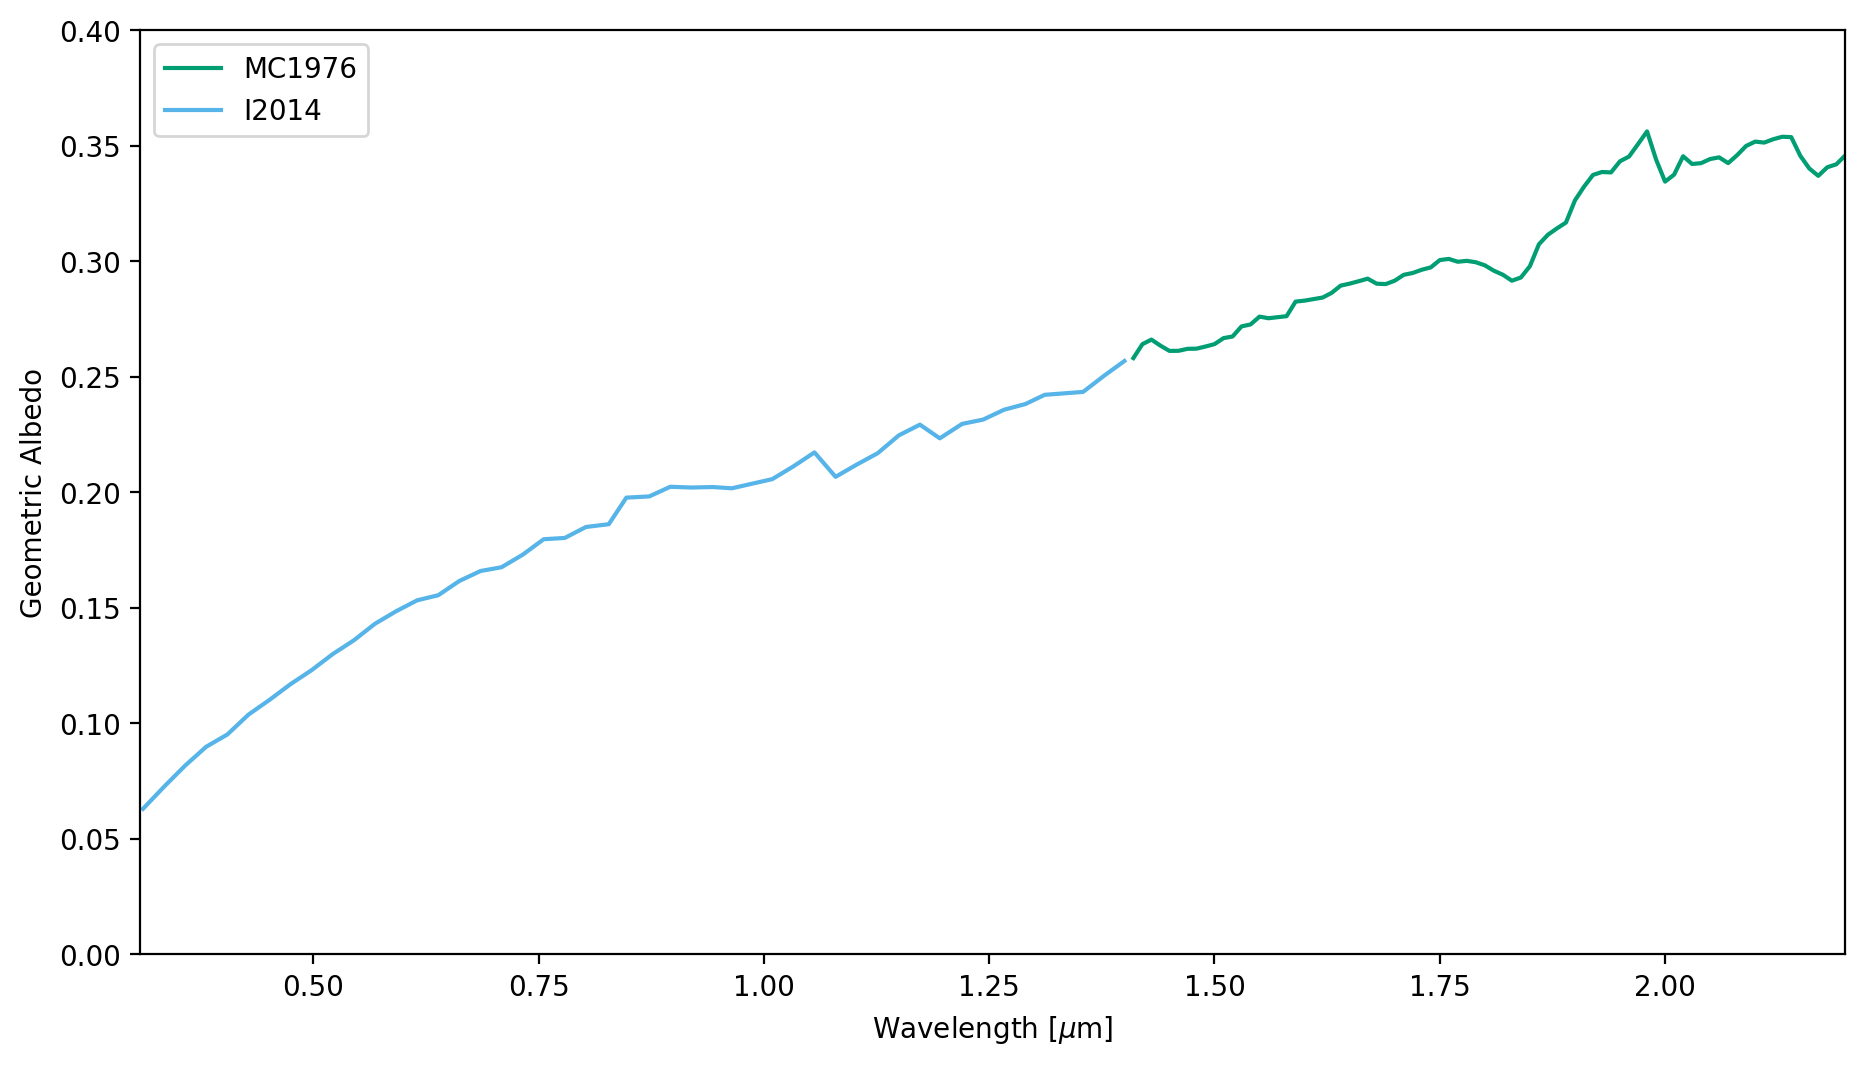

In [12]:
plt.figure(figsize=(11,6), dpi=200)

plt.plot(mccord_digitized[(mccord_digitized['x']<2.2) & (mccord_digitized['x']>1.41)]['x'],(mccord_digitized[(mccord_digitized['x']<2.2) & (mccord_digitized['x']>1.41)]['y']/get_scale_factor_LS(77.4))*0.66, color=cb_palette[2], label='MC1976')
plt.plot(izenberg2014[izenberg2014['x']<1.41]['x'],izenberg2014[izenberg2014['x']<1.41]['y']*2, label='I2014', color=cb_palette[-1])
# plt.scatter(mallama2017[:,0],mallama2017[:,1], color=cb_palette[0], label='M2017')
# plt.errorbar(mallama2017[:,0], mallama2017[:,1], xerr=mallama2017[:,2]/2,fmt='o', color=cb_palette[0])#linestyle='none'

plt.legend()
plt.ylim(0,0.4)
plt.xlim(min(domingue_digitized['x']),2.2)
plt.xlabel('Wavelength [$\mu$m]')
plt.ylabel('Geometric Albedo')
plt.savefig('final_plots/mercury_composite.png', bbox_inches="tight");